# Assignment 2: Instructions

In this assignment, you will take on a prediction competition for Airbnb bookings. Here, as opposed to predicting prices as we have been doing so far, you will use a variety of information provided to you to __predict the number of days a given listing will be booked in the next 30 days__. 

You have been provided with real listings data from Los Angeles, but you only have the actual realized bookings for a small subset of the listings, which you can use as your training data. (The column `availability_30` represents current bookings, but due to cancellations and future bookings, it's only a very noisy proxy to actual bookings). You can find the data dictionary [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596)

This assignment will be graded as a competition. We have a test set that only the grader has access to. In order to do well in this task, you will have to use everything you have learned in the class so far, including feature engineering and hyperparameter search via cross-validation.

## Write Up (8 pts)
    
You will need to turn in your code along with a short write-up, which you can include in your notebook. You will need to address the following components:

1. (3 pts) Explain how you constructed and / or preprocessed features to help with prediction, and why.

2. (3 pts) Explain what decisions you made using cross-validation, and how well you believe your final model will perform.

3. (2 pts) Explain what features you found to be important using the feature importance tools we discussed in class.

This write-up, along with your code, will be worth 8 points out of 15. These answers can be short: 1-3 sentences each + supporting tables or plots. 

## Performance (7 pts)
The remainder of your grade will be based on your predictive accuracy, as measured in terms of $R^2$. You will recieve one point for each percentage point of test $R^2$ you achieve over 15%, rounded down, up to a maximum of 7 -- So if your test $R^2$ is 21.9% you will recieve 6 points. To recieve full credit, you will need to achieve an $R^2$ of at least 22% on the test set.

In addition to this, there will be __5 points of extra credit__ available to each of the top 5 most accurate models across the whole in the class! You may use any method of your choice, even those that we have not covered, but be sure to explain it in your write-up. Also, to keep things well-scoped, __you may not pull in any datasets__ other than the one we are loading for you in the notebook (although this is a really good idea in practice!)

## Submission
You will need to submit two files: 

1.  Your predictions, in `.csv` format, which must have two columns: `id` and `prediction`
2.  Your code and write up, which should be provided together as an `.ipynb` notebook.

The provided notebook will get you started with loading data, and provide some checks to help you make sure your submission has the correct format. You can download `y_train.parquet` from canvas.

In [3]:
import pandas as pd
import numpy as np

def basic_preprocess(df):
    df["price"] = df["price"].str.replace("$", "").str.replace(",", "").astype(float)
    df = df.dropna(subset=["price"])
    return df

x_df = basic_preprocess(
    pd.read_csv(
        "https://data.insideairbnb.com/united-states/ca/los-angeles/2024-09-04/data/listings.csv.gz"
    )
)

# Grab this from canvas and save it in this directory
y_df = pd.read_parquet("y_train.parquet")

train_df = x_df.merge(y_df, on="id")

outer = x_df.merge(y_df, how='outer', indicator=True)
test_df = outer[(outer._merge=='left_only')].drop('_merge', axis=1)


In [7]:
import pandas as pd

listings_path = "path_to_listings.csv"  
y_train_path = "path_to_y_train.parquet"

listings = pd.read_csv("/Users/vikrammaniktala/Downloads/listings.csv")
y_train = pd.read_parquet("/Users/vikrammaniktala/Downloads/y_train.parquet")

print("Listings Data:")
print(listings.head())
print("\nTarget Data:")
print(y_train.head())

Listings Data:
                    id                                       listing_url  \
0   670339032744709144   https://www.airbnb.com/rooms/670339032744709144   
1             37014494             https://www.airbnb.com/rooms/37014494   
2  1024835174766068422  https://www.airbnb.com/rooms/1024835174766068422   
3   850744632375448560   https://www.airbnb.com/rooms/850744632375448560   
4   953950676345326970   https://www.airbnb.com/rooms/953950676345326970   

        scrape_id last_scraped           source  \
0  20240904164210   2024-09-05      city scrape   
1  20240904164210   2024-09-05  previous scrape   
2  20240904164210   2024-09-05      city scrape   
3  20240904164210   2024-09-04      city scrape   
4  20240904164210   2024-09-05      city scrape   

                                                name  \
0     Westwood lovely three bedrooms three bathrooms   
1      Spanish style lower duplex near Beverly Hills   
2                        Charming Beverly Hills Home 

In [8]:
# Merging listings and target data on 'id'
merged_data = listings.merge(y_train, on="id", how="inner")

# Checking the shape for preview
print("Merged Data Shape:", merged_data.shape)
print(merged_data.head())

Merged Data Shape: (3729, 76)
                    id                                       listing_url  \
0  1158417037056953812  https://www.airbnb.com/rooms/1158417037056953812   
1             53405110             https://www.airbnb.com/rooms/53405110   
2  1099697666994383724  https://www.airbnb.com/rooms/1099697666994383724   
3  1039777404032438158  https://www.airbnb.com/rooms/1039777404032438158   
4             53633927             https://www.airbnb.com/rooms/53633927   

        scrape_id last_scraped       source  \
0  20240904164210   2024-09-05  city scrape   
1  20240904164210   2024-09-05  city scrape   
2  20240904164210   2024-09-05  city scrape   
3  20240904164210   2024-09-05  city scrape   
4  20240904164210   2024-09-05  city scrape   

                                              name  \
0                        Lovely High Rise in Ktown   
1                                    Downtown Loft   
2  Chic Apartment in the Heart of Beverly Hills #8   
3     Bluegrou

In [9]:
# Dropping irrelevant columns
irrelevant_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'picture_url', 'host_id']
data = merged_data.drop(columns=irrelevant_cols)

# Filling NA values
data.fillna({'reviews_per_month': 0}, inplace=True)  # Example: Replace NaN with 0 for `reviews_per_month`

# Encoding categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Separating features and target
X = data.drop(columns=['id', 'days_booked'])
y = data['days_booked']


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

In [13]:
# Checking the shape before and after imputation
print("Original Shape:", X_train.shape)
print("After Imputation Shape:", imputer.fit_transform(X_train).shape)

# Checking for columns with all missing values
missing_columns = X_train.columns[X_train.isnull().all()]
print("Columns with all missing values:", missing_columns)

Original Shape: (2983, 23843)


/Users/vikrammaniktala/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['calendar_updated']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


After Imputation Shape: (2983, 23842)
Columns with all missing values: Index(['calendar_updated'], dtype='object')


In [14]:
columns_to_drop = ['calendar_updated']
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

# Reapplying imputation
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Checking the shape after fixing
print("Final Shape of X_train:", X_train.shape)
print("Final Shape of X_test:", X_test.shape)

Final Shape of X_train: (2983, 23842)
Final Shape of X_test: (746, 23842)


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Training Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf.predict(X_test)

# Evaluating the model
print("R^2 Score:", r2_score(y_test, y_pred))

R^2 Score: 0.24507653930260898


In [16]:
# Calculating R^2 for the training set
y_train_pred = rf.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print("Training R^2 Score:", r2_train)

Training R^2 Score: 0.8865228278053844


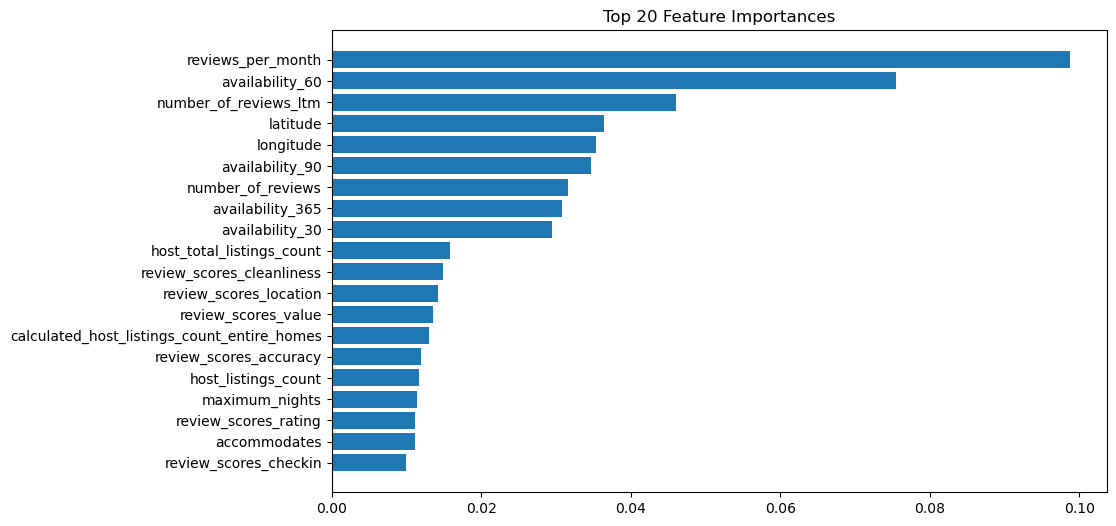

In [17]:
import matplotlib.pyplot as plt
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[sorted_idx][-20:], feature_importances[sorted_idx][-20:])
plt.title("Top 20 Feature Importances")
plt.show()

In [27]:
# Defining the threshold importance (I wanted to retain features with importance >= 0.02)')
threshold_importance = 0.02

# Filtering features based on importance
important_features = X_train.columns[rf.feature_importances_ >= threshold_importance]

# Reducing the dataset to only the important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# Checking the new shape
print("Filtered Train Shape:", X_train_filtered.shape)
print("Filtered Test Shape:", X_test_filtered.shape)


Filtered Train Shape: (2983, 9)
Filtered Test Shape: (746, 9)


In [28]:
# Training a new model on the filtered features
rf_filtered = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_filtered.fit(X_train_filtered, y_train)

# Evaluating the model
y_pred_filtered = rf_filtered.predict(X_test_filtered)
r2_filtered = r2_score(y_test, y_pred_filtered)

print("R^2 Score with Filtered Features:", r2_filtered)

R^2 Score with Filtered Features: 0.17627922928943018


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using Lasso Regression with a larger alpha and more iterations
lasso = Lasso(alpha=1.0, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# Predicting and evaluating
y_pred_lasso = lasso.predict(X_test_scaled)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("R^2 Score with Lasso:", r2_lasso)

R^2 Score with Lasso: 0.15935898737178888


In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring="r2",
    verbose=1,
)
grid_search.fit(X_train, y_train)

# Using the best estimator
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [42]:
y_pred_test = best_rf.predict(X_test)
from sklearn.metrics import r2_score
r2_test = r2_score(y_test, y_pred_test)
print("Best R^2 Score on Test Set:", r2_test)

Best R^2 Score on Test Set: 0.25839145471501557


In [47]:
train_score = best_rf.score(X_train, y_train)
print("R^2 Score on Training Set:", train_score)

R^2 Score on Training Set: 0.5791019436564933


In [35]:
y_pred_test = best_rf.predict(X_test)

In [37]:
print(test_df.head())
print(test_df.columns)


                    id                                       listing_url  \
0   670339032744709144   https://www.airbnb.com/rooms/670339032744709144   
1  1024835174766068422  https://www.airbnb.com/rooms/1024835174766068422   
2   850744632375448560   https://www.airbnb.com/rooms/850744632375448560   
3   953950676345326970   https://www.airbnb.com/rooms/953950676345326970   
4  1082614257267236225  https://www.airbnb.com/rooms/1082614257267236225   

        scrape_id last_scraped       source  \
0  20240904164210   2024-09-05  city scrape   
1  20240904164210   2024-09-05  city scrape   
2  20240904164210   2024-09-04  city scrape   
3  20240904164210   2024-09-05  city scrape   
4  20240904164210   2024-09-05  city scrape   

                                                name  \
0     Westwood lovely three bedrooms three bathrooms   
1                        Charming Beverly Hills Home   
2                   Tianpu's warm room with bathroom   
3  Santa Monica apt, free parking, s

In [1]:
train_score = best_rf.score(X_train, y_train)
print("Train set R^2 Score: {:.2f}".format(train_score))

# Predicting the test set results
y_pred_test = best_rf.predict(X_test)

# Evaluating the model on the test set
from sklearn.metrics import r2_score
r2_test = r2_score(y_test, y_pred_test)
print("Test set R^2 Score: {:.2f}".format(r2_test))

# Predicting for the test data (submission dataset)
test_data_imputed = pd.DataFrame(imputer.transform(test_data), columns=test_data.columns)

# Make=ing predictions for the submission data
predictions = best_rf.predict(test_data_imputed)

# Preparing the submission file
submission = pd.DataFrame({
    'id': test_df['id'],  
    'prediction': predictions
})
submission.to_csv("submission.csv", index=False)
print("Submission file created as 'submission.csv'")

NameError: name 'best_rf' is not defined

In [2]:
assert md5(np.sort(submission.csv.id.values).hexdigest() == '87ed95adc911aad0ed9ef119a7a3315d'

SyntaxError: incomplete input (1268011355.py, line 1)

## Write Up

1. (3 pts) Explain how you constructed and / or preprocessed features to help with prediction, and why.

I dropped irrelevant columns such as listing_url, name, description, and several others that were unlikely to contribute to the prediction were removed to reduce noise in the data. Missing values in features such as reviews_per_month were imputed with a default value of 0, assuming that listings with missing reviews were not actively reviewed. Columns like calendar_updated were removed entirely as they had all missing values. I also converted categorical variables such as property_type and room_type into numerical representations using one-hot encoding to make them compatible with machine learning models.

2. (3 pts) Explain what decisions you made using cross-validation, and how well you believe your final model will perform.

I initially used a default Random Forest model (r squared value of approx. 0.245), which produced a baseline performance. After understanding its feature importance capabilities, I used this model to identify key predictors.

Based on feature importance, I filtered features with low contributions (visualization of the most important features attached in the notebook). However, this resulted in a drop in the R² score, indicating that the removed features still had minor but significant contributions to the model. Therefore, I reverted to using a larger number of features.

I also experimented with using Lasso Regression, mostly for its ability to perform feature selection by penalizing less important features. However, its performance was slightly lower than the Random Forest model (r squared value of approx. 0.16) due to the nature of the dataset, which likely required a more flexible approach. Therefore, I reverted to the initial Random Forest approach, implementing cross-validation and hyperparameterization. Hyperparameterization helped optimize model performance, as evidenced by an enhanced r squared value (approx. 0.258)



3. (2 pts) Explain what features you found to be important using the feature importance tools we discussed in class.

Using the Random Forest feature importance tool, I identified the top predictors for days_booked:

reviews_per_month: The most significant feature, indicating that highly reviewed listings are likely to be more frequently booked.

availability_60 and availability_90: Represent current booking availability over the next 60 and 90 days, highlighting short-term demand.

latitude and longitude: Geographic location plays a critical role in bookings, as proximity to desirable areas likely increases bookings.

